In [1]:
from langgraph.graph import StateGraph,START,END,MessagesState
from typing import List,Literal,TypedDict,Optional,Dict
from pydantic_ai.messages import ModelMessagesTypeAdapter,ModelMessage
from pydantic_ai import Agent,RunContext,Tool
from langgraph.types import interrupt, Command,Literal
from dotenv import load_dotenv
from pydantic import BaseModel,Field
from dataclasses import dataclass
from langgraph.checkpoint.memory import MemorySaver
from langchain_experimental.utilities import PythonREPL
import nest_asyncio
import asyncio
load_dotenv()

True

In [2]:
nest_asyncio.apply()

In [3]:
memory = MemorySaver()
config = {'configurable':{'thread_id':'1'}}


In [4]:

class Response(BaseModel):
    csv_file_name : str = Field(description="Name of the CSV file to be created")
    csv_file_path : str = Field(description="Path of the CSV file to be created")
    goal: List[str] = Field(description="Goals to be done by the agent defined by the user")
    next_question : str = Field(description="Next question to ask based on remaining fields")
    got_all : bool = Field(description="True if all fields are filled else False")


In [5]:

class Supervision(BaseModel):
    go_to: Literal["preprocessor_agent", "__end__"] = Field(
        description="The next agent which needs to be called"
    )
    command: str = Field(description="Prompt or order for the next agent should be prompts")
    finished: bool = Field(description="True if all goals have been completed")
    finished_tasks : List[str] = Field(description="List of tasks which have been completed")
    final_answer : Optional[str] = Field(description="Reply to be given to the user")

In [6]:

info_gathering_agent = Agent(
    'google-gla:gemini-2.0-flash',
    result_type=Response,
    system_prompt="""You are part of EDA (Exploratory Data Analysis) team. 
    Your task is to gather information about the data name and the goal of the user.
    Ask the user to provide the name of the csv file and the path where it is located.
    Then ask the user to provide the goals they want to achieve with the data.
    Once all fields are filled, you will return the CSV file name and path along with a message indicating that all fields have been filled.
    Always add finding data description and the data type as the first goal if any data is provided.
    Your goals are prompts to a supervisor agent.Which will use other agent to look into the data.
    """,
)

In [7]:
@dataclass
class task_monitoring:
    tasks_done : List[str] = Field(description="List of tasks which have been completed")
    response : str = Field(description="Response from the agent which did the task")
    execution_output : str = Field(description="Output of the agent after executing the task")
    code : str = Field(description="Code generated by the agent to do the task")


In [8]:
supervisor_agent = Agent(
    'google-gla:gemini-2.0-flash',
    result_type=Supervision,
    system_prompt="""You are a supervisor agent, You can give commands to other agent named preprocessing agent. 
    One agent is preprocessing agent it can be used to analyze the data ,describe the data and its structure.
    You will give commands to the agents based on the information provided and can write
    This agent has python sandbox to execute data analysis tasks.
    You will also keep track of the tasks completed by the agent and the tasks remaining.""",
    deps_type= task_monitoring,
)

In [9]:
class Preprocess(BaseModel):
    tasks_done : List[str] = Field(description="A brief description of the task done by the agent")
    finished_task : bool = Field(description="True if all tasks have been completed")
    response : str = Field(description="Response of the agent after executing the task")
    code_execution_output : str = Field(description="Output of the agent after executing the task")
    code : str = Field(description="Code executed by the agent")


In [10]:
@dataclass
class file_details:
    file_name:str
    file_path:str

In [11]:
python_agent = Agent(
    'google-gla:gemini-2.0-flash',
    result_type=Preprocess,
    tools=[PythonREPL().run],
    system_prompt="""You are a data preprocessing agent. You will be provided a csv file name and path.
    You will be given a command to follow. You should use pandas and numpy libraries to preprocess the data.
    You can also use other libraries if needed. You will also be given a python sandbox to execute the code.
    """,
    deps_type=file_details,
)

In [12]:
class State(TypedDict):
    user_input : str 
    messages : List = Field(default=[])
    details : Response
    supervision : Supervision
    preprocess : Preprocess

In [13]:
def where_to_go(state:State)->Command[Literal['get_next_user_msg','supervisor']]:
    if state['details'].got_all:
        return 'supervisor'
    else:
        return 'get_next_user_msg'

In [14]:
async def get_user_info(state: State):

    message_history = state['messages']
    
    response = await info_gathering_agent.run(
        state['user_input'],
        message_history=message_history
    )
    state['details'] = response.data
    state['messages'] = message_history + response.new_messages()
    
    return state

In [15]:
async def get_next_msg(state:State):
    value = interrupt({})
    state['user_input']=value  
    return state

In [16]:
async def supervisor(state:State):
    if state['preprocess'].tasks_done == []:
        message_history = state['messages']
        details = state['details']
        prompt = "".join([str(i+1)+". "+ j + "\n\n" for i,j in enumerate(details.goal)])
        response = await supervisor_agent.run(prompt,message_history=message_history)
        state['supervision'] = response.data
        state['messages'] = message_history + response.new_messages()
    
    else:
        message_history = state['messages']
        details = state['details']
        prompt = "".join([str(i+1)+". "+ j + "\n\n" for i,j in enumerate(details.goal)])

        @supervisor_agent.system_prompt
        def get_system_prompt(ctx:RunContext[task_monitoring])->str:
            tasks_done = ctx.deps.tasks_done
            response_from_agent = ctx.deps.response
            execution_output = ctx.deps.execution_output
            code = ctx.deps.code
            return f"""Here are the tasks done and the response from the agent {tasks_done} and {response_from_agent}.
            The output from the latest execution {execution_output}, and the code generated by the agent {code}.
            You can use this information to give next commands or end.
            Always remeber to keep track of outputs and by the end give the answers to the user.
            """

        tasks_montoring = task_monitoring(
            tasks_done = state['preprocess'].tasks_done,
            response = state['preprocess'].response,
            execution_output = state['preprocess'].code_execution_output,
            code = state['preprocess'].code,
        )

        response = await supervisor_agent.run(prompt,message_history=message_history,deps=tasks_montoring)
        state['supervision'] = response.data
        state['messages'] = message_history + response.new_messages()

    return state

In [17]:
def agent_selection(state:State)->Command[Literal['preprocessor_agent','__end__']]:
    if state['supervision'].go_to == 'preprocessor_agent':
        return 'preprocessor_agent'
    else:
        return '__end__'


In [18]:
async def preprocess_agent(state:State):
    
    @python_agent.system_prompt
    def get_system_prompt(ctx: RunContext[file_details]) -> str:  
        csv_name  = ctx.deps.file_name
        csv_path = ctx.deps.file_path
        return f'Prompt: Here is the file name and path of the csv file: {csv_name} and {csv_path}. \n\n'

    file_info = file_details(
        file_name=state['details'].csv_file_name,
        file_path=state['details'].csv_file_path
    )

    prompt = state['supervision'].command

    response_3 = await python_agent.run(
    prompt,
    deps=file_info,
    )
    
    state['preprocess'] = response_3.data
    state['messages'] = state['messages'] + response_3.new_messages()

    return state


In [19]:
graph_builder = StateGraph(State)

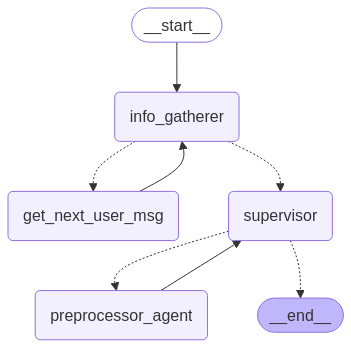

In [20]:
graph_builder.add_node("info_gatherer",get_user_info)
graph_builder.add_node("get_next_user_msg",get_next_msg)
graph_builder.add_node("supervisor",supervisor)
graph_builder.add_node("preprocessor_agent",preprocess_agent)
graph_builder.add_conditional_edges("info_gatherer",where_to_go,{'get_next_user_msg':'get_next_user_msg','supervisor':'supervisor'})
graph_builder.add_conditional_edges("supervisor",agent_selection,{'preprocessor_agent':'preprocessor_agent','__end__':END})


graph_builder.add_edge(START,"info_gatherer")
graph_builder.add_edge("get_next_user_msg","info_gatherer")
graph_builder.add_edge("preprocessor_agent","supervisor")
graph_builder.compile()

In [21]:
graph = graph_builder.compile(checkpointer=memory)

In [23]:
# Cell [13] - Corrected
from pydantic_ai.messages import ModelMessagesTypeAdapter,ModelMessage # Ensure ModelMessage is imported if needed, though not directly used here

# Create a default initial Response state
initial_details = Response(
    csv_file_name="",
    csv_file_path="",
    goal=[],
    next_question="",
    got_all=False
)
initial_supervision = Supervision(go_to="__end__", command="", finished=False, finished_tasks=[], final_answer=None)
initial_preprocess = Preprocess(tasks_done=[], finished_task=False, response="", code_execution_output="", code="")


response = await graph.ainvoke({
    'user_input': "Hello! The dataset name is users_data.csv and the path is in the D:/PROJECT_MULTIMODEL/Pydantic_ai/eda_pydantic/users_data.csv. Find the columns and their data types ",
    'messages': [],
    'details': initial_details,
    'supervision': initial_supervision,
    'preprocess': initial_preprocess
},config=config)

print(response)


Python REPL can execute arbitrary code. Use with caution.


{'user_input': 'Hello! The dataset name is users_data.csv and the path is in the D:/PROJECT_MULTIMODEL/Pydantic_ai/eda_pydantic/users_data.csv. Find the columns and their data types ', 'messages': [ModelRequest(parts=[SystemPromptPart(content='You are part of EDA (Exploratory Data Analysis) team. \n    Your task is to gather information about the data name and the goal of the user.\n    Ask the user to provide the name of the csv file and the path where it is located.\n    Then ask the user to provide the goals they want to achieve with the data.\n    Once all fields are filled, you will return the CSV file name and path along with a message indicating that all fields have been filled.\n    Always add finding data description and the data type as the first goal if any data is provided.\n    Your goals are prompts to a supervisor agent.Which will use other agent to look into the data.\n    ', timestamp=datetime.datetime(2025, 4, 13, 17, 53, 40, 226485, tzinfo=datetime.timezone.utc), dyn

In [24]:
response

{'user_input': 'Hello! The dataset name is users_data.csv and the path is in the D:/PROJECT_MULTIMODEL/Pydantic_ai/eda_pydantic/users_data.csv. Find the columns and their data types ',
 'messages': [ModelRequest(parts=[SystemPromptPart(content='You are part of EDA (Exploratory Data Analysis) team. \n    Your task is to gather information about the data name and the goal of the user.\n    Ask the user to provide the name of the csv file and the path where it is located.\n    Then ask the user to provide the goals they want to achieve with the data.\n    Once all fields are filled, you will return the CSV file name and path along with a message indicating that all fields have been filled.\n    Always add finding data description and the data type as the first goal if any data is provided.\n    Your goals are prompts to a supervisor agent.Which will use other agent to look into the data.\n    ', timestamp=datetime.datetime(2025, 4, 13, 17, 53, 40, 226485, tzinfo=datetime.timezone.utc), dy

In [38]:
def print_final_results(response):
    """Print a nicely formatted summary of the LangGraph execution results"""
    
    print("\n" + "="*50)
    print("📊 DATA ANALYSIS RESULTS 📊".center(50))
    print("="*50 + "\n")
    
    # Print basic dataset info
    print(f"📂 Dataset: {response['details'].csv_file_name}")
    print(f"🔗 Path: {response['details'].csv_file_path}")
    print(f"🎯 Goals completed: {', '.join(response['supervision'].finished_tasks)}")
    print("\n" + "-"*50 + "\n")
    
    # Print the main result (the final answer)
    if response['supervision'].final_answer:
        print("📝 FINDINGS:")
        print(response['supervision'].final_answer)
    
    # Print code used (optional)
    print("\n" + "-"*50)
    print("💻 Code executed:")
    print(f"```python\n{response['preprocess'].code}\n```")
    print("="*50)

In [40]:
print_final_results(response)


            📊 DATA ANALYSIS RESULTS 📊             

📂 Dataset: users_data.csv
🔗 Path: D:/PROJECT_MULTIMODEL/Pydantic_ai/eda_pydantic/users_data.csv
🎯 Goals completed: finding data description and the data type

--------------------------------------------------

📝 FINDINGS:
The data has 2000 rows and 14 columns. The column names and their data types are as follows:
id: int64
current_age: int64
retirement_age: int64
birth_year: int64
birth_month: int64
gender: object
address: object
latitude: float64
longitude: float64
per_capita_income: object
yearly_income: object
total_debt: object
credit_score: int64
num_credit_cards: int64

--------------------------------------------------
💻 Code executed:
```python
import pandas as pd

df = pd.read_csv("D:/PROJECT_MULTIMODEL/Pydantic_ai/eda_pydantic/users_data.csv")

data_description = df.info()

print(data_description)
```
